## Overland Flow Scratchwork

First get the necessary libraries

In [3]:
import numpy as np
from matplotlib.pyplot import figure

from landlab.components import OverlandFlow
from landlab import RasterModelGrid
from landlab.grid.mappers import map_max_of_node_links_to_node
from landlab.plot import imshow

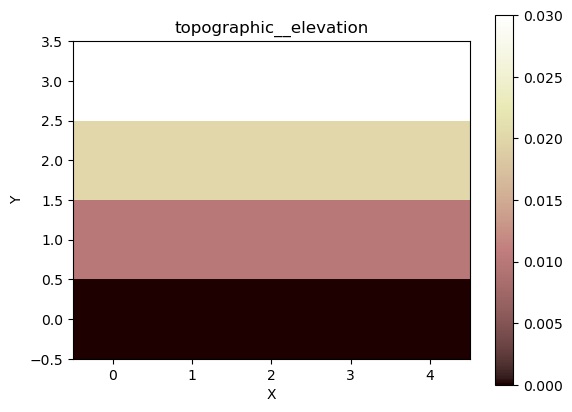

In [4]:
#Define grid
grid = RasterModelGrid((4, 5))

#add topographic values to field
z = grid.node_y*0.01  # a flat surface dipping shallowly south
# create the field:
grid.add_field('node', 'topographic__elevation', z, units='m')

#plot elevation
figure('elevation')
imshow.imshow_grid_at_node(grid, "topographic__elevation")

In [5]:
#add surface water depth (1 m everywhere)
grid.add_ones("surface_water__depth", at = "node", clobber = True)



array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

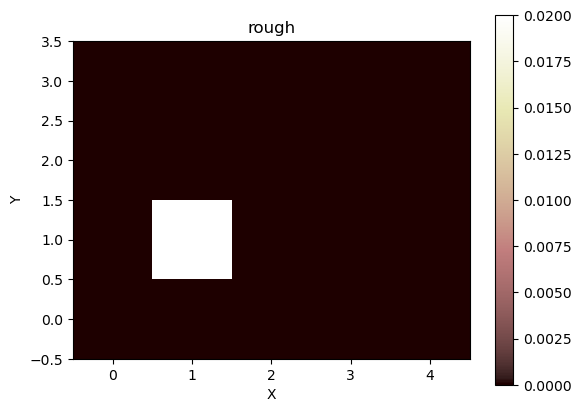

In [6]:
#now add rouughness
grid.add_zeros("rough",  at = "node", clobber=True)

#create some variation
grid.at_node["rough"][6] = 0.02

#plot roughness
figure('mannings_n')
imshow.imshow_grid_at_node(grid, "rough")

In [7]:
#map roughness to link
r = grid.map_mean_of_link_nodes_to_link("rough")

#add to grid
grid.add_field("mannings_n", r, at = "link", clobber=True)

#check that they are there
grid.at_link.keys()


['mannings_n']

In [8]:
grid.at_link.keys()

['mannings_n']

['mannings_n',
 'surface_water__depth',
 'water_surface__gradient',
 'surface_water__discharge']

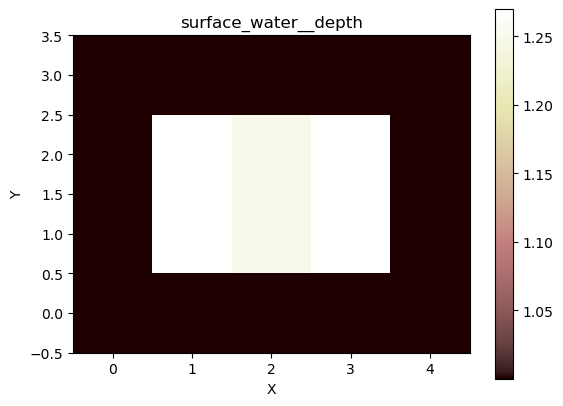

In [11]:


#init overland flow model
of = OverlandFlow(grid, mannings_n = "mannings_n", rainfall_intensity=1, steep_slopes=True)

#run model one step
of.run_one_step()

#plot water depth
figure('water depth')
imshow.imshow_grid_at_node(grid, "surface_water__depth")

grid.at_link.keys()

